In [2]:
import sys, os, re; sys.path = (["../../src/", "../../"] if re.match(r'^(\w\:\\)|(/)', os.getcwd()) else [])+ sys.path 

import qubx
%qubxd

%load_ext autoreload
%autoreload 2

from qubx import lookup, logger
from qubx.core.interfaces import IStrategy, TriggerEvent, PositionsTracker, IStrategyContext
from qubx.pandaz.utils import *
import qubx.pandaz.ta as pta

# - - - - - - - - - - - - - - - - - - - - - - - -
from qubx.trackers.riskctrl import AtrRiskTracker
from qubx.ta.indicators import sma, ema
from qubx.data.readers import CsvStorageDataReader, MultiQdbConnector, AsPandasFrame
from qubx.core.basics import Deal, Instrument, Order, Position, Signal

from qubx.backtester.simulator import simulate
from qubx.core.metrics import tearsheet
from qubx.trackers.sizers import FixedSizer, FixedRiskSizer
from qubx.core.metrics import chart_signals


⠀⠀⡰⡖⠒⠒⢒⢦⠀⠀   
⠀⢠⠃⠈⢆⣀⣎⣀⣱⡀  QUBX | Quantitative Backtesting Environment 
⠀⢳⠒⠒⡞⠚⡄⠀⡰⠁         (c) 2024, ver. Dev
⠀⠀⠱⣜⣀⣀⣈⣦⠃⠀⠀⠀ 
        


# Strategy for signals testing

In [3]:
class StrategyForTracking(IStrategy):
    timeframe: str = "1Min"
    fast_period = 5
    slow_period = 12

    def on_fit(self, ctx: IStrategyContext):
        logger.info(f" -> Fit is called | fit_time: {ctx.time()}")

    def on_event(self, ctx: IStrategyContext, event: TriggerEvent) -> list[Signal] | None:
        signals = []
        for i in ctx.instruments:
            ohlc = ctx.ohlc(i, self.timeframe)
            fast = sma(ohlc.close, self.fast_period)
            slow = sma(ohlc.close, self.slow_period)
            pos = ctx.get_position(i).quantity

            if pos <= 0 and (fast[0] > slow[0]) and (fast[1] < slow[1]):
                signals.append(i.signal(+1, stop=ohlc[1].low))

            if pos >= 0 and (fast[0] < slow[0]) and (fast[1] > slow[1]):
                signals.append(i.signal(-1, stop=ohlc[1].high))

        return signals

    def tracker(self, ctx: IStrategyContext) -> PositionsTracker:
        return PositionsTracker(FixedRiskSizer(1, 10_000, reinvest_profit=True))

In [ ]:
r = CsvStorageDataReader("../tests/data/csv")

rep = simulate({
        "As Strategy 1": [
            StrategyForTracking(timeframe="15Min", fast_period=5, slow_period=25),
        ],

        "As Strategy 2": [
            StrategyForTracking(timeframe="15Min", fast_period=5, slow_period=25),
            AtrRiskTracker(10, 5, '15Min', 50, atr_smoother='kama', sizer=FixedRiskSizer(0.5))
        ]
    },
    {"ohlc(15Min)" : r}, 10000, [ "BINANCE.UM:BTCUSDT" ], 
    "vip0_usdt", 
    "2024-01-01", "2024-01-05", debug="ERROR"
)

  0%|          | 0/2 [00:00<?, ?it/s]

Simulating:   0%|          | 0/100 [00:00<?, ?%/s]

Simulating:   0%|          | 0/100 [00:00<?, ?%/s]

,,Gain,Cagr,Sharpe,Qr,Max dd pct,Mdd usd,Sortino,Calmar,Tail ratio,Stability,Var,Avg return,Fees,Execs
id,,,,,,,,,,,,,,,
0,As Strategy 1,97.803276,1.034999,1.823429,-0.001641,10.051438,1102.735755,3.293065,30.791225,0.886043,0.469471,310.454196,0.215376,224.611924,23.0
1,As Strategy 2,15.702992,0.121360,1.440130,-0.002864,1.503987,151.581246,3.700622,19.530641,1.737226,0.674825,59.459074,0.032110,38.632158,24.0


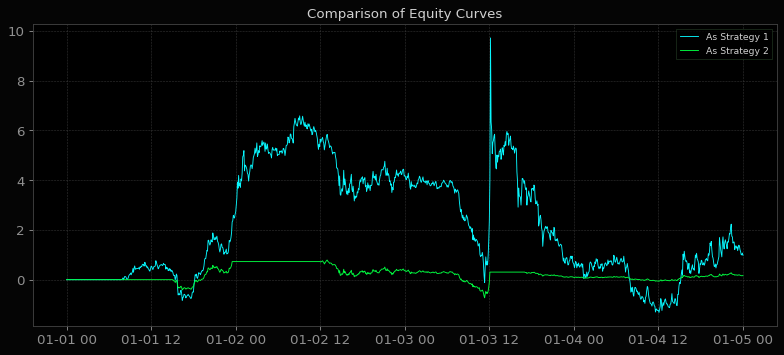

In [5]:
tearsheet(rep)

In [6]:
rep[1].executions_log

,instrument_id,exchange_id,side,filled_qty,price,commissions,commissions_quoted
timestamp,,,,,,,
2024-01-01 15:00:00,BTCUSDT,BINANCE.UM,sell,-0.085,42645.55,1.812436,USDT
2024-01-01 15:45:00,BTCUSDT,BINANCE.UM,buy,0.170,42885.65,3.645280,USDT
2024-01-01 23:27:36,BTCUSDT,BINANCE.UM,sell,-0.085,44053.40,0.748908,USDT
2024-01-02 12:00:00,BTCUSDT,BINANCE.UM,sell,-0.055,45486.75,1.250886,USDT
2024-01-02 14:15:00,BTCUSDT,BINANCE.UM,buy,0.110,45815.35,2.519844,USDT
2024-01-02 15:00:00,BTCUSDT,BINANCE.UM,sell,-0.109,45293.55,2.468498,USDT
2024-01-02 22:45:00,BTCUSDT,BINANCE.UM,buy,0.105,44956.65,2.360224,USDT
2024-01-02 23:30:00,BTCUSDT,BINANCE.UM,sell,-0.102,44999.05,2.294952,USDT
2024-01-03 01:00:00,BTCUSDT,BINANCE.UM,buy,0.102,45168.15,2.303576,USDT


In [7]:
rep[0].signals_log

,instrument_id,exchange_id,signal,target_position,reference_price,price,take,stop,group,comment,service
timestamp,,,,,,,,,,,
2024-01-01 07:45:00,BTCUSDT,BINANCE.UM,1,0.235,42475.4,None,None,42463.1,StrategyForTracking,,False
2024-01-01 15:00:00,BTCUSDT,BINANCE.UM,-1,-0.234,42645.6,None,None,42700.0,StrategyForTracking,,False
2024-01-01 15:45:00,BTCUSDT,BINANCE.UM,1,0.233,42885.6,None,None,42666.6,StrategyForTracking,,False
2024-01-02 12:00:00,BTCUSDT,BINANCE.UM,-1,-0.219,45486.8,None,None,45614.9,StrategyForTracking,,False
2024-01-02 14:15:00,BTCUSDT,BINANCE.UM,1,0.218,45815.3,None,None,45635.2,StrategyForTracking,,False
2024-01-02 15:00:00,BTCUSDT,BINANCE.UM,-1,-0.220,45293.6,None,None,45714.0,StrategyForTracking,,False
2024-01-02 22:45:00,BTCUSDT,BINANCE.UM,1,0.222,44956.6,None,None,45070.0,StrategyForTracking,,False
2024-01-02 23:30:00,BTCUSDT,BINANCE.UM,-1,-0.222,44999.1,None,None,45042.9,StrategyForTracking,,False
2024-01-03 01:00:00,BTCUSDT,BINANCE.UM,1,0.221,45168.1,None,None,44907.7,StrategyForTracking,,False


# Atr Tracker + generated signals

In [8]:
r = MultiQdbConnector('nebula')
rep = simulate(
    {
        "test0": [pd.Series(
            {
                "2024-01-01 10:00": 1,
                # "2024-01-02 12:00": 0,
                "2024-01-02 12:00": 1,
                "2024-01-03 10:00": -1,
                "2024-01-04 15:00": 0,

                "2024-01-04 16:00": 1,
                "2024-01-04 16:10": 2,
                "2024-01-05 17:00": 0,
            }, name='BTCUSDT'), 
                  AtrRiskTracker(5, 5, '5Min', 32, sizer=FixedRiskSizer(0.5))
            ],
    },
    {"ohlc(1Min)": r}, 10000, ["BINANCE.UM:BTCUSDT"], 
    "vip0_usdt", "2024-01-01", "2024-01-05", debug="DEBUG"
)

2024-01-01 00:00:00.000 [🐞] [simulator] :: Preparing simulated trading on BINANCE.UM for 10000 USDT...
2024-01-01 00:00:00.000 [ℹ️] SimulatedDataProvider.binance.um is initialized


Simulating:   0%|          | 0/100 [00:00<?, ?%/s]

2024-01-01 00:00:00.000 [🐞] SignalsProxy new parameters:
	set timeframe <- 1Min
2024-01-01 00:00:00.000 [🐞] [SimulatedDataProvider] :: Using pre-generated signals:
 7
2024-01-01 00:00:00.000 [🐞] [simulator] :: Setting default schedule: */1 * * * *
2024-01-01 00:00:00.000 [🐞] [simulator] :: Strategy didn't set warmup period for ohlc(1Min) so default 5Min will be used
2024-01-01 00:00:00.000 [ℹ️] SimulatedDataProvider ::: Simulation started at 2024-01-01 00:00:00 :::
2024-01-01 00:00:00.000 [🐞]   [IteratedDataStreamsSlicer] :: Preloading initial data for ohlc.1Min 2024-01-01 00:00:00 : 2024-01-05 00:00:00 ...
2024-01-01 00:00:05.000 [🐞] [ProcessingManager] :: Invoking SignalsProxy on_fit
2024-01-01 00:00:05.000 [🐞] [ProcessingManager] :: SignalsProxy is fitted
2024-01-01 10:00:00.000 [🐞] [BrokerSideRiskController(BINANCE.UM:FUTURE:BTCUSDT)] :: New signal: Target +0.237000 for SignalsProxy 42688.80 +1.000000 BINANCE.UM:FUTURE:BTCUSDT stop: 42478.459375000006 take: 42899.240625000006
2024-

,Gain,Cagr,Sharpe,Qr,Max dd pct,Mdd usd,Sortino,Calmar,Tail ratio,Stability,Var,Avg return,Fees,Execs
test0,71.121,0.909,7.054,0.092,0.914,92.11,15.077,167.279,1.12,0.241,50.936,0.178,17.609,9.0


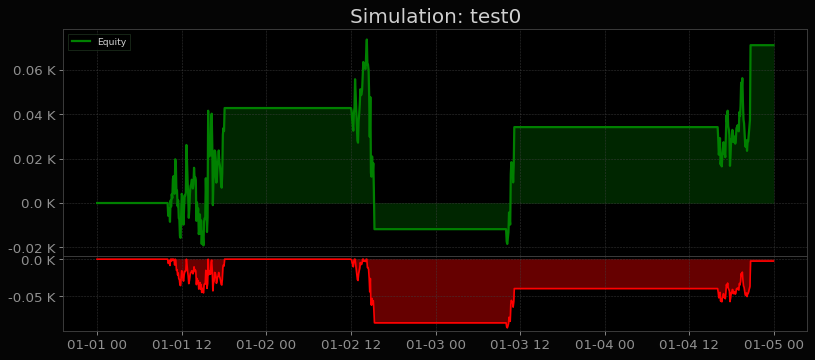

In [12]:
tearsheet(rep, False)

In [29]:
rep[0].executions_log

,instrument_id,side,filled_qty,price,commissions,commissions_quoted
timestamp,,,,,,
2024-01-01 10:00:00.001,BTCUSDT,buy,0.237,42688.85,5.058629,USDT
2024-01-01 18:01:36.000,BTCUSDT,sell,-0.237,42908.35,5.084639,USDT
2024-01-02 12:00:00.001,BTCUSDT,buy,0.100,45486.85,2.274343,USDT
2024-01-02 15:17:36.000,BTCUSDT,sell,-0.100,44932.95,2.246647,USDT
2024-01-03 10:00:00.001,BTCUSDT,sell,-0.115,45378.55,2.609267,USDT
2024-01-03 11:08:36.000,BTCUSDT,buy,0.115,44928.55,2.583392,USDT
2024-01-04 16:00:00.001,BTCUSDT,buy,0.072,44050.45,1.585816,USDT
2024-01-04 16:10:00.001,BTCUSDT,sell,-0.002,43899.65,0.043900,USDT
2024-01-04 20:38:36.000,BTCUSDT,sell,-0.070,44840.75,1.569426,USDT


In [11]:
rep[0].signals_log

,instrument_id,exchange_id,signal,target_position,reference_price,price,take,stop,group,comment,service
timestamp,,,,,,,,,,,
2024-01-01 10:00:00,BTCUSDT,BINANCE.UM,1,0.237,42688.8,NaN,42899.240625,42478.459375,SignalsProxy,,False
2024-01-01 18:01:36,BTCUSDT,BINANCE.UM,0,0.000,NaN,42899.3,NaN,NaN,Risk Manager,Take triggered,True
2024-01-02 12:00:00,BTCUSDT,BINANCE.UM,1,0.101,45486.8,NaN,45982.162500,44991.537500,SignalsProxy,,False
2024-01-02 15:17:36,BTCUSDT,BINANCE.UM,0,0.000,NaN,44991.6,NaN,NaN,Risk Manager,Stop triggered,True
2024-01-03 10:00:00,BTCUSDT,BINANCE.UM,-1,-0.117,45378.7,NaN,44953.868750,45803.431250,SignalsProxy,,False
2024-01-03 11:08:36,BTCUSDT,BINANCE.UM,0,0.000,NaN,44953.8,NaN,NaN,Risk Manager,Take triggered,True
2024-01-04 15:00:00,BTCUSDT,BINANCE.UM,0,0.000,43674.0,NaN,NaN,NaN,SignalsProxy,,False
2024-01-04 16:00:00,BTCUSDT,BINANCE.UM,1,0.072,44050.4,NaN,44745.590625,43355.309375,SignalsProxy,,False
2024-01-04 16:10:00,BTCUSDT,BINANCE.UM,2,0.071,43899.7,NaN,44603.968750,43195.531250,SignalsProxy,,False


In [13]:
ohlc_pd1 = r.read('BINANCE.UM:BTCUSDT', '2024-01-01', '2024-02-05', AsPandasFrame())
ohlc_pd = ohlc_resample(ohlc_pd1, '5Min')

In [ ]:
chart_signals(rep[0], "BTCUSDT", ohlc_pd1, overlay=[
        ohlc_pd.close - 5*pta.atr(ohlc_pd, 32),
        ohlc_pd.close + 5*pta.atr(ohlc_pd, 32),
    ], info=0)